In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout


Using TensorFlow backend.


In [7]:
con=sqlite3.connect('./FPA_FOD_20170508.sqlite')

df = pd.read_sql_query("SELECT * From Fires", con)
df.head()


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [8]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#print(cursor.fetchall())
cursor.close()
con.close()

In [ ]:
def to_csv():
    con=sqlite3.connect('./FPA_FOD_20170508.sqlite')

    cursor = con.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    for table_name in tables:
        table_name = table_name[0]
        #if (table_name != 'SpatialIndex' and table_name != 'ElementaryGeometries' and table_name != 'KNN') :
        if (table_name == 'Fires'):
            table = pd.read_sql_query("SELECT * From {}".format(table_name), con)
            table.to_csv(table_name + '.csv', index_label='index')
    cursor.close()
    con.close()

In [ ]:
to_csv()

In [9]:
# Remove unwanted cols
df = df.drop(['STATE', 'COUNTY','FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE_CLASS', 'OWNER_CODE', 'OWNER_DESCR',
       'FIPS_CODE', 'FIPS_NAME', 'Shape','DISCOVERY_TIME'], axis=1)

In [10]:
print(df.columns) 

Index(['OBJECTID', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE',
       'FIRE_SIZE', 'LATITUDE', 'LONGITUDE'],
      dtype='object')


In [11]:
# Check for Nan values
df.isnull().values.any()
df1 = df[df.isna().any(axis=1)]
print(df1)

Empty DataFrame
Columns: [OBJECTID, DISCOVERY_DATE, DISCOVERY_DOY, STAT_CAUSE_CODE, FIRE_SIZE, LATITUDE, LONGITUDE]
Index: []


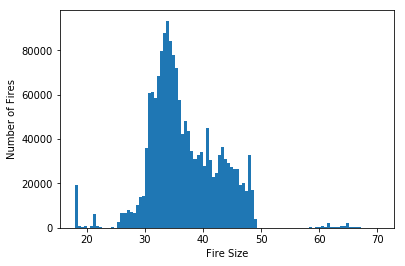

In [32]:
#Distibution of fire size
plt.hist(y_train, bins=100);
plt.ylabel('Number of Fires')
plt.xlabel('Fire Size')
plt.show()

In [12]:
#Changing pandas dataframe to numpy array
Y = df.iloc[:,5:6].values
X = np.concatenate( (df.iloc[:,:5].values, df.iloc[:,6:].values), axis = 1 )
print(Y[0:3])
print(X[0:3,:])


[[40.03694444]
 [38.93305556]
 [38.98416667]]
[[ 1.00000000e+00  2.45340350e+06  3.30000000e+01  9.00000000e+00
   1.00000000e-01 -1.21005833e+02]
 [ 2.00000000e+00  2.45313750e+06  1.33000000e+02  1.00000000e+00
   2.50000000e-01 -1.20404444e+02]
 [ 3.00000000e+00  2.45315650e+06  1.52000000e+02  5.00000000e+00
   1.00000000e-01 -1.20735556e+02]]


In [13]:
#Normalize the data
sc = StandardScaler()
X = sc.fit_transform(X)

In [14]:
# Train/Test split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.1)
print("# Train: {} , #Test: {}".format(X_train.shape[0], X_test.shape[0]))
print("# inputs: {}".format(X_train.shape[1]))
n = X_train.shape[1]

# Train: 1692418 , #Test: 188047
# inputs: 6


In [15]:
# Neural network
model = Sequential()
model.add(Dense(32, input_dim=n, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, input_dim=n , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [17]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [18]:
#Save partly trained model
#model.save('partly_trained.h5')

#Load partly trained model
from keras.models import load_model
#model = load_model('partly_trained.h5')

#Continue training
model.fit(X_train, y_train, epochs=10, batch_size=640, verbose = 2, validation_split = 0.1, shuffle=True)

Train on 1523176 samples, validate on 169242 samples
Epoch 1/10
 - 21s - loss: 48.6595 - mse: 48.6595 - mae: 4.9291 - val_loss: 159.8331 - val_mse: 159.8331 - val_mae: 11.9100
Epoch 2/10
 - 21s - loss: 20.4192 - mse: 20.4192 - mae: 3.4406 - val_loss: 133.1046 - val_mse: 133.1046 - val_mae: 10.8512
Epoch 3/10
 - 23s - loss: 15.3836 - mse: 15.3836 - mae: 2.9336 - val_loss: 109.4478 - val_mse: 109.4478 - val_mae: 9.7820
Epoch 4/10
 - 22s - loss: 12.6226 - mse: 12.6226 - mae: 2.5990 - val_loss: 92.5370 - val_mse: 92.5370 - val_mae: 8.9279
Epoch 5/10
 - 22s - loss: 11.2375 - mse: 11.2375 - mae: 2.4050 - val_loss: 87.6749 - val_mse: 87.6748 - val_mae: 8.6104
Epoch 6/10
 - 22s - loss: 10.3881 - mse: 10.3881 - mae: 2.2884 - val_loss: 76.3893 - val_mse: 76.3893 - val_mae: 8.0076
Epoch 7/10
 - 22s - loss: 9.8409 - mse: 9.8409 - mae: 2.2102 - val_loss: 70.1878 - val_mse: 70.1878 - val_mae: 7.5780
Epoch 8/10
 - 23s - loss: 9.4053 - mse: 9.4053 - mae: 2.1467 - val_loss: 63.0735 - val_mse: 63.0735 -

In [18]:
#Save partly trained model
#model.save('partly_trained.h5')

#Load partly trained model
from keras.models import load_model
model = load_model('partly_trained.h5')


_, mse, mae = model.evaluate(X_test, y_test)
print('MSE: %.2f, MAE: %.2f' % (mse,mae))

188047/188047 [==============================] - 4s 20us/step
MSE: 52.54, MAE: 6.25


188047/188047 [==============================] - 3s 16us/step


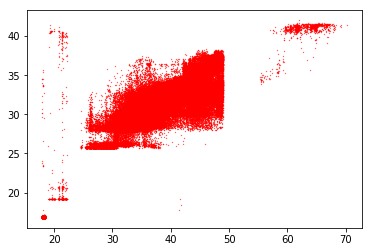

In [22]:
#Visualize some predictions
preds = model.predict(X_test, verbose=1)
plt.scatter(y_test, preds, s=0.3, marker='.', c='r')
plt.show()

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

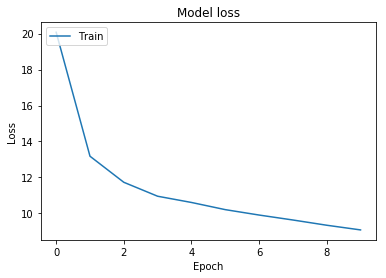

In [99]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()